In [ ]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from tqdm import tqdm
import math
from matplotlib.gridspec import GridSpec
from typing import Dict, List

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wiesruyters/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"

Helper functions

In [43]:
COUNTRY_CONFIGS = {
    'NL': {
        'parties': [
            'PVV', 'GL-PvdA', 'VVD', 'NSC', 'D66', 'BBB', 
            'CDA', 'SP', 'FVD', 'PvdD', 'CU', 'SGP', 
            'DENK', 'Volt', 'JA21', 'BIJ1', 'BVNL'
        ],
        'party_variants': {
            'PVV': ['PVV', 'Partij voor de Vrijheid'],
            'GL-PvdA': [
                'PvdA-GL', 'GL-PvdA', 'GL/PvdA', 'PvdA/GL',
                'GroenLinks/PvdA', 'PvdA/GroenLinks',
                'GroenLinks-PvdA', 'PvdA-GroenLinks'
            ],
            'NSC': ['NSC', 'Nieuw Sociaal Contract'],
            'BBB': ['BBB', 'BoerBurgerBeweging'],
            'FVD': ['FVD', 'Forum voor Democratie'],
            'PvdD': ['PvdD', 'Partij voor de Dieren'],
            'CU': ['CU', 'ChristenUnie']
        },
        'politicians': [
            'Geert Wilders', 'Frans Timmermans', 'Dilan Yesilgöz', 'Pieter Omtzigt',
            'Rob Jetten', 'Caroline van der Plas', 'Henri Bontebal', 'Lilian Marijnissen',
            'Thierry Baudet', 'Esther Ouwehand', 'Mirjam Bikker', 'Chris Stoffer',
            'Stephan van Baarle', 'Laurens Dassen', 'Joost Eerdmans', 'Edson Olf',
            'Wybren van Haga'
        ],
        'stopwords': {
            'dutch': True,
            'custom': {
                'zeg', 'zegt', 'zeggen', 'word', 'worden', 'ga', 'gaan',
                'moet', 'moeten', 'kan', 'kunnen', 'wil', 'willen',
                'heb', 'heeft', 'hebben', 'maak', 'maakt', 'maken'
            }
        }
    },
    'UK': {
        'parties': [
            'Labour Party', 'Conservative Party', 'Reform UK', 'Liberal Democrats',
            'Green Party of England and Wales', 'Scottish National Party', 'Sinn Féin',
            "Workers' Party of Britain", 'Plaid Cymru', 'Democratic Unionist Party',
            'Alliance Party of Northern Ireland', 'Ulster Unionist Party',
            'Scottish Greens', 'Social Democratic and Labour Party',
            'Traditional Unionist Voice'
        ],
        'party_variants': {
            'Labour Party': ['Labour', 'Lab'],
            'Conservative Party': ['Conservative', 'Conservatives', 'Tory', 'Tories'],
            'Liberal Democrats': ['Lib Dem', 'Lib Dems'],
            'Green Party of England and Wales': ['Green Party', 'Greens'],
            'Scottish National Party': ['SNP'],
            "Workers' Party of Britain": ["Workers' Party", 'Workers Party'],
            'Democratic Unionist Party': ['DUP'],
            'Alliance Party of Northern Ireland': ['Alliance'],
            'Ulster Unionist Party': ['UUP'],
            'Social Democratic and Labour Party': ['SDLP'],
            'Traditional Unionist Voice': ['TUV']
        },
        'politicians': [
            'Keir Starmer', 'Rishi Sunak', 'Nigel Farage', 'Ed Davey',
            'Carla Denyer', 'Adrian Ramsay', 'John Swinney', 'Mary Lou McDonald',
            'George Galloway', 'Rhun ap Iorwerth', 'Gavin Robinson', 'Naomi Long',
            'Doug Beattie', 'Patrick Harvie', 'Lorna Slater', 'Colum Eastwood',
            'Jim Allister'
        ],
        'stopwords': {
            'english': True,
            'custom': {
                'say', 'says', 'said', 'tell', 'tells', 'told', 'go', 'goes', 'went',
                'must', 'should', 'could', 'would', 'will', 'have', 'has', 'had',
                'make', 'makes', 'made'
            }
        }
    }
}

def create_party_subsets(df, country_config, text_columns=['title', 'paragraphs', 'alt_txt']):
    """
    Function to isolate articles that specifically mention certain political parties and their politicians.
    :df: Dataframe storing specific articles
    :country_config: Constant that stores the country-specific wordlists
    :text_columns: column pointers indicating where in the dataframe to perform the search
    """
    party_subsets = {}
    parties = country_config['parties']
    politicians = country_config['politicians']
    party_variants = country_config.get('party_variants', {})
    
    with tqdm(parties, desc="Isolating party-relevant articles...") as pbar:
        for party in pbar:
            
            # Ensure all mentions of this party are found...
            variants = party_variants.get(party, [party])
            pattern = re.compile(
                r'\b(?:{})\b'.format('|'.join(map(re.escape, variants))),
                re.IGNORECASE
            )
            
            # Find the party leaders belonging to this party...
            party_politicians = [
                p for p in politicians 
                if any(re.search(rf'\b{re.escape(v)}\b', p, re.IGNORECASE) 
                      for v in variants)
            ]
            
            politician_patterns = [
                re.compile(rf'\b{re.escape(p)}\b', re.IGNORECASE) 
                for p in party_politicians
            ]
            
            # Mask the relevant articles
            mask = df[text_columns].apply(
                lambda col: col.str.contains(pattern, na=False) | 
                any(col.str.contains(p, na=False) for p in politician_patterns)
            ).any(axis=1)
            
            party_subsets[party] = df[mask].copy()
            pbar.set_postfix({'articles': len(party_subsets[party])})
    
    return party_subsets

def generate_word_clouds(party_subsets, country_config, cols=3, figsize=(20, 20)):
    """
    Generate word clouds with country-specific stopwords
    :party_subsets: Relevant articles to include for this party
    :country_config: Constant that stores the country-specific wordlists
    :cols: Number of wordclouds to display in one row
    :figsize: Max size of figures displaying hte wordclouds
    """
    # Import stopwords (best practice)
    from nltk.corpus import stopwords as nltk_stopwords
    
    # Initialisation
    stopword_set = set()
    
    # Add language-specific stopwords
    if 'dutch' in country_config['stopwords'] and country_config['stopwords']['dutch']:
        stopword_set.update(set(nltk_stopwords.words('dutch')))
    if 'english' in country_config['stopwords'] and country_config['stopwords']['english']:
        stopword_set.update(set(nltk_stopwords.words('english')))
    
    # Add custom stopwords from COUNTRY_CONFIG
    stopword_set.update(country_config['stopwords']['custom'])
    
    # In case of parties with no articles
    valid_parties = {k: v for k, v in party_subsets.items() if len(v) > 0}
    n_parties = len(valid_parties)
    
    if n_parties == 0:
        print("No articles found for any party")
        return
    
    # Set grid dimension and create figure
    rows = math.ceil(n_parties / cols)
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(rows, cols, figure=fig)
    
    text_columns = ['title', 'paragraphs', 'alt_txt']
    
    for idx, (party, df) in enumerate(tqdm(valid_parties.items(), desc="Generating the WordClouds...")):
        row = idx // cols
        col = idx % cols
        
        ax = fig.add_subplot(gs[row, col])
        combined_text = df.apply(
            lambda row: ' '.join(str(row[col]) for col in text_columns),
            axis=1
        ).str.cat(sep=' ')
        
        wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            font_path=font_path,
            stopwords=stopword_set,
            max_words=100
        ).generate(combined_text)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{party} (n={len(df)})', fontsize=12)
        ax.axis('off')
    
    plt.suptitle('Word Clouds by Political Party\n\n', fontsize=20, y=1.02)
    plt.show()

def get_top_words(party_subsets, country_config, n=20):
    """
    Get top words for each party with country-specific stopwords
    :party_subsets: Party-specific relevant articles
    :country_config: Constant that stores the country-specific wordlists
    :n: Number of top_words to return
    """
    from nltk.corpus import stopwords as nltk_stopwords
    
    # Initialize stopwords set
    stopword_set = set()
    
    # Add language-specific stopwords
    if 'dutch' in country_config['stopwords'] and country_config['stopwords']['dutch']:
        stopword_set.update(set(nltk_stopwords.words('dutch')))
    if 'english' in country_config['stopwords'] and country_config['stopwords']['english']:
        stopword_set.update(set(nltk_stopwords.words('english')))
    
    # Add custom stopwords (stored in COUNTRY_CONFIG)
    stopword_set.update(country_config['stopwords']['custom'])
    
    vectorizer = CountVectorizer(stop_words=list(stopword_set), max_features=1000)
    top_words = {}
    text_columns = ['title', 'paragraphs', 'alt_txt']
    
    for party, df in tqdm(party_subsets.items(), desc="Extracting top 20 words..."):
        if len(df) == 0:
            top_words[party] = []
            continue
            
        combined_text = df.apply(
            lambda row: ' '.join(str(row[col]) for col in text_columns),
            axis=1
        ).str.cat(sep=' ')
        
        X = vectorizer.fit_transform([combined_text])
        word_counts = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
        sorted_words = sorted(word_counts, key=lambda x: x[1], reverse=True)[:int(n)]
        
        top_words[party] = [word for word, count in sorted_words]
    
    return top_words

def perform_lda_analysis(party_subsets, country_config, n_topics=3, n_words=5):
    """
    Simple LDA analysis for each party
    :party_subsets: Party-specific relevant articles
    :n_topics: Number of topics
    n_words: Top features
    """
    from nltk.corpus import stopwords as nltk_stopwords

    # Initialize stopwords set
    stopword_set = set()
    
    # Add language-specific stopwords
    if 'dutch' in country_config['stopwords'] and country_config['stopwords']['dutch']:
        stopword_set.update(set(nltk_stopwords.words('dutch')))
    if 'english' in country_config['stopwords'] and country_config['stopwords']['english']:
        stopword_set.update(set(nltk_stopwords.words('english')))
    
    # Add custom stopwords (stored in COUNTRY_CONFIG)
    stopword_set.update(country_config['stopwords']['custom'])
    
    vectorizer = CountVectorizer(stop_words=list(stopword_set), max_features=1000)
    lda = LatentDirichletAllocation(n_components=3, random_state=2)
    
    lda_results = {}
    
    # LDA Latent Dirichlet Allocation / Basic Topic Modeling
    for party, df in tqdm(party_subsets.items(), desc="Extracting topics with LDA..."):
        if len(df) < 10:
            lda_results[party] = "Not enough data (needs at least 10 articles)"
            continue
            
        combined_texts = df.apply(
            lambda row: ' '.join(str(row[col]) for col in ['title', 'paragraphs', 'alt_txt']),
            axis=1
        )
        
        X = vectorizer.fit_transform(combined_texts)
        lda.fit(X)
        
        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            top_features_ind = topic.argsort()[:-n_words - 1:-1]
            top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
            topics.append(top_features)
        
        lda_results[party] = topics
    
    return lda_results

def analyze_party_mentions(df, country):
    """
    Main analysis function with country support
    :df: All articles
    :country: National context
    """
    
    def preprocess_text(text):
        if pd.isna(text):
            return ""
        return text
    
    # Normalize country input to prevent mismatch
    country = country.upper() if len(country) <= 2 else country.lower()
    config = COUNTRY_CONFIGS.get(country)
    
    if not config:
        available = ", ".join(f"'{c}'" for c in COUNTRY_CONFIGS.keys())
        raise ValueError(f"Unsupported country: {country}. Available options: {available}")
    
    # Circumvent textual errors and NaN values
    for col in tqdm(['title', 'paragraphs', 'alt_txt'], desc="Preprocessing text"):
        df[col] = df[col].apply(preprocess_text)
    
    # Create party-specific relevant articles
    party_subsets = create_party_subsets(df, config)
    
    # Generate the WordClouds for all political parties
    generate_word_clouds(party_subsets, config)
    
    # Get the n top words for this country
    top_words = get_top_words(party_subsets, country_config=config, n=20)
    
    # LDA analysis
    lda_results = perform_lda_analysis(party_subsets, config)
    
    return party_subsets, top_words, lda_results

# NL

In [44]:
nl_articles = pd.read_parquet('../b__data-collection-with-web-scraping/datasets/news/nl_articles_preprocessed.parquet')

For the Netherlands, the function *analyze_party_mentions* takes approximately 22 seconds

Generating the WordClouds...: 100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


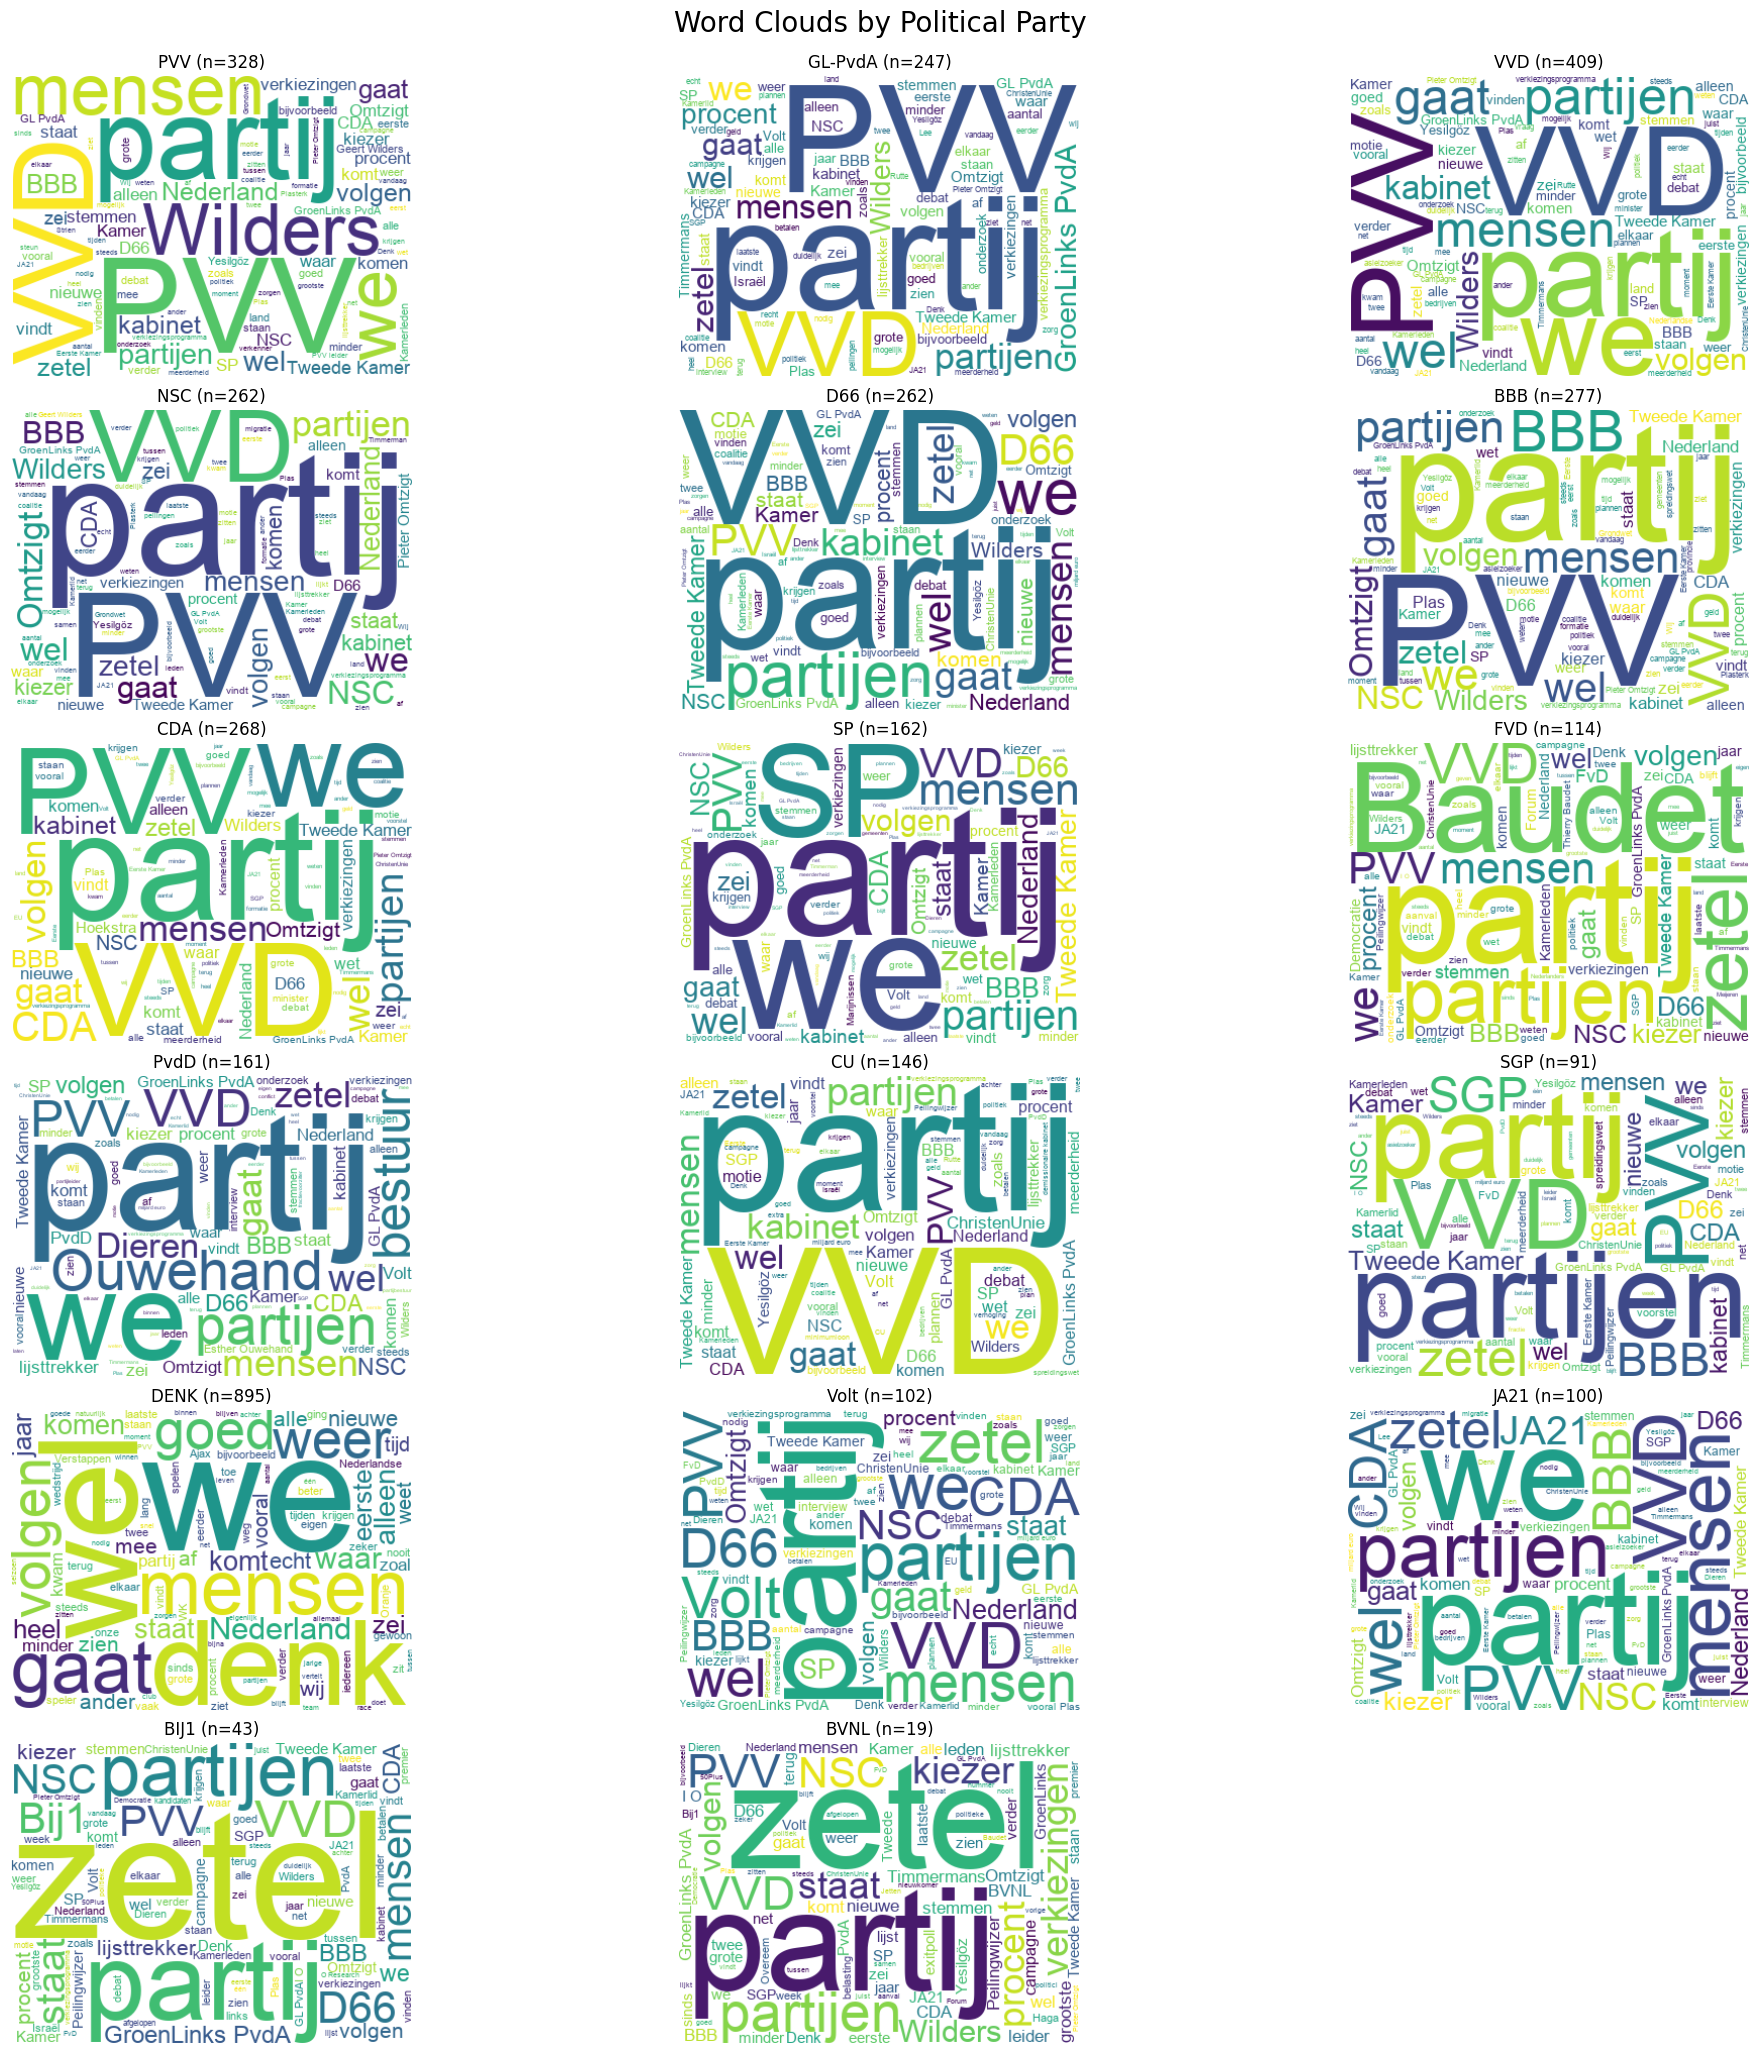

Extracting topics with LDA...: 100%|██████████| 17/17 [00:11<00:00,  1.52it/s]


In [45]:
nl_party_subsets, nl_top_words, nl_lda_results = analyze_party_mentions(nl_articles, 'NL')

In [46]:
nl_top_words_df = pd.DataFrame(nl_top_words)
nl_lda_results_df = pd.DataFrame(nl_lda_results)

In [47]:
nl_top_words_df

PVV     GL-PvdA       VVD       NSC         D66       BBB       CDA  \
0         pvv    partijen       vvd       vvd    partijen       pvv    partij   
1         vvd         vvd       pvv       pvv         vvd       vvd       vvd   
2     wilders         pvv  partijen    partij       kamer  partijen  partijen   
3      partij      partij    partij  partijen      partij    partij     kamer   
4       kamer        pvda     kamer   omtzigt         d66       bbb       cda   
5    partijen       kamer        we       nsc         pvv     kamer       pvv   
6     kabinet      tweede   kabinet   wilders     kabinet       nsc   kabinet   
7      tweede          we    tweede        we          we   omtzigt        we   
8          we  groenlinks   wilders     kamer        pvda        we   omtzigt   
9      mensen     wilders    mensen   kabinet      tweede    tweede    tweede   
10        nsc     omtzigt       wel       bbb         wel   wilders      pvda   
11    omtzigt         nsc       nsc      pvda      mensen    mensen       nsc   
12        wel      mensen   omtzigt       wel        gaat   kabinet       wel   
13        bbb         d66      pvda    tweede         nsc       wel    mensen   
14     leider         wel      gaat      gaat     wilders      gaat       bbb   
15       pvda        gaat       zei    mensen         cda       cda       d66   
16        zei     kabinet       bbb  yesilgöz        jaar      pvda      gaat   
17       gaat      zetels      jaar       zei  groenlinks    leider   volgens   
18   yesilgöz     procent  yesilgöz    leider     omtzigt      jaar    nieuwe   
19  nederland  timmermans   volgens       cda      zetels   volgens   wilders   

          SP       FVD          PvdD            CU         SGP       DENK  \
0   partijen    partij        partij         kamer       kamer         we   
1     partij  partijen      partijen      partijen    partijen        wel   
2      kamer    baudet      ouwehand           vvd         vvd       jaar   
3         sp       pvv            we        partij      partij       denk   
4         we     kamer           vvd       kabinet         pvv     mensen   
5     mensen       vvd       bestuur          pvda        pvda       heel   
6        pvv    tweede         kamer        tweede      tweede       goed   
7        vvd      pvda           pvv           d66         d66       gaat   
8     tweede        we          pvda           pvv      zetels       weer   
9       pvda    mensen  lijsttrekker           cda         nsc     eerste   
10       wel    zetels        mensen            we         sgp       waar   
11      jaar       fvd        tweede          jaar     kabinet       twee   
12       d66   volgens           wel        mensen         cda    volgens   
13    zetels       wel           d66  christenunie         bbb  nederland   
14   kabinet       d66           nsc          gaat          we     alleen   
15   volgens       nsc        dieren        zetels  groenlinks       zien   
16       nsc   procent          gaat           wel     omtzigt       komt   
17      gaat       bbb        zetels           nsc        gaat     nieuwe   
18   omtzigt   kiezers       omtzigt           bbb      eerste      komen   
19       cda    leider           cda    groenlinks      nieuwe      staat   

            Volt      JA21        BIJ1          BVNL  
0       partijen  partijen    partijen        partij  
1         partij    partij      partij      partijen  
2            vvd        we      zetels        zetels  
3           pvda       vvd        pvda          pvda  
4          kamer    mensen       kamer           pvv  
5             we     kamer         vvd           vvd  
6            d66       pvv      tweede    groenlinks  
7            pvv      pvda         pvv       wilders  
8            cda       bbb         nsc           nsc  
9           volt       wel         d66        tweede  
10        zetels       cda  groenlinks       omtzigt  
11           nsc      ja21    

In [48]:
nl_lda_results_df

PVV  \
0      [pvv, wilders, vvd, leider, kabinet]   
1       [mensen, partijen, partij, pvv, we]   
2  [kamer, tweede, pvv, kamerleden, eerste]   

                                          GL-PvdA  \
0            [pvv, vvd, partij, wilders, omtzigt]   
1           [partijen, mensen, procent, we, euro]   
2  [kamer, tweede, kabinet, kamerlid, kamerleden]   

                                   VVD  \
0  [mensen, partijen, jaar, euro, vvd]   
1    [partij, vvd, we, partijen, pvda]   
2  [pvv, vvd, kamer, wilders, kabinet]   

                                        NSC  \
0  [procent, jaar, nederland, pvv, stemmen]   
1     [pvv, wilders, vvd, kabinet, omtzigt]   
2      [partijen, partij, omtzigt, we, nsc]   

                                      D66  \
0   [pvv, vvd, partij, wilders, partijen]   
1  [partijen, d66, we, partij, onderzoek]   
2       [kamer, kabinet, we, d66, tweede]   

                                      BBB  \
0  [partij, partijen, pvda, omtzigt, vvd]   
1      [mensen, bbb, jaar, we, nederland]   
2     [pvv, vvd, wilders, kamer, kabinet]   

                                       CDA  \
0         [vvd, pvv, wilders, we, omtzigt]   
1     [partij, zetels, omtzigt, cda, pvda]   
2  [kamer, partijen, mensen, kabinet, cda]   

                                      SP  \
0   [pvv, partij, vvd, zetels, partijen]   
1     [mensen, we, partijen, euro, jaar]   
2  [kamer, sp, tweede, wet, marijnissen]   

                                              FVD  \
0          [baudet, fvd, aanval, thierry, leider]   
1  [kamer, tweede, kamerleden, stemmen, kamerlid]   
2              [partijen, partij, pvv, vvd, pvda]   

                                         PvdD  \
0        [pvv, vvd, partij, partijen, zetels]   
1           [we, partijen, mensen, wel, gaat]   
2  [ouwehand, bestuur, partij, kamer, dieren]   

                                        CU  \
0     [kamer, zetels, kabinet, vvd, motie]   
1  [partijen, euro, mensen, procent, jaar]   
2           [partij, kamer, vvd, pvv, cda]   

                                         SGP  \
0  [zetels, partij, partijen, kiezers, pvda]   
1    [partijen, euro, sgp, procent, miljard]   
2    [kamer, vvd, tweede, kabinet, partijen]   

                                    DENK  \
0            [we, wel, jaar, heel, goed]   
1  [verstappen, we, partij, pvv, tweede]   
2       [we, mensen, wel, jaar, volgens]   

                                           Volt  \
0            [kamer, pvv, tweede, zei, wilders]   
1         [partijen, partij, pvda, zetels, vvd]   
2  [we, nederland, lijsttrekker, mensen, kamer]   

                                    JA21  \
0  [pvv, partij, zetels, partijen, pvda]   
1    [partijen, euro, vvd, procent, d66]   
2       [we, kamer, mensen, partij, bbb]   

                                      BIJ1  \
0     [partijen, mensen, bij1, partij, we]   
1    [zetels, partij, partijen, pvda, vvd]   
2  [kamer, kabinet, tweede, kamerlid, cda]   

                                             BVNL  
0      [belasting, staat, overeem, lijst, partij]  
1           [partij, partijen, pvda, zetels, pvv]  
2  [zetels, peilingwijzer, partij, partijen, bbb]

# UK

In [49]:
uk_articles = pd.read_parquet('../b__data-collection-with-web-scraping/datasets/news/uk_articles_preprocessed.parquet')

For the United Kingdom, the function *analyze_party_mentions* takes approximately 3m52s

Generating the WordClouds...: 100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


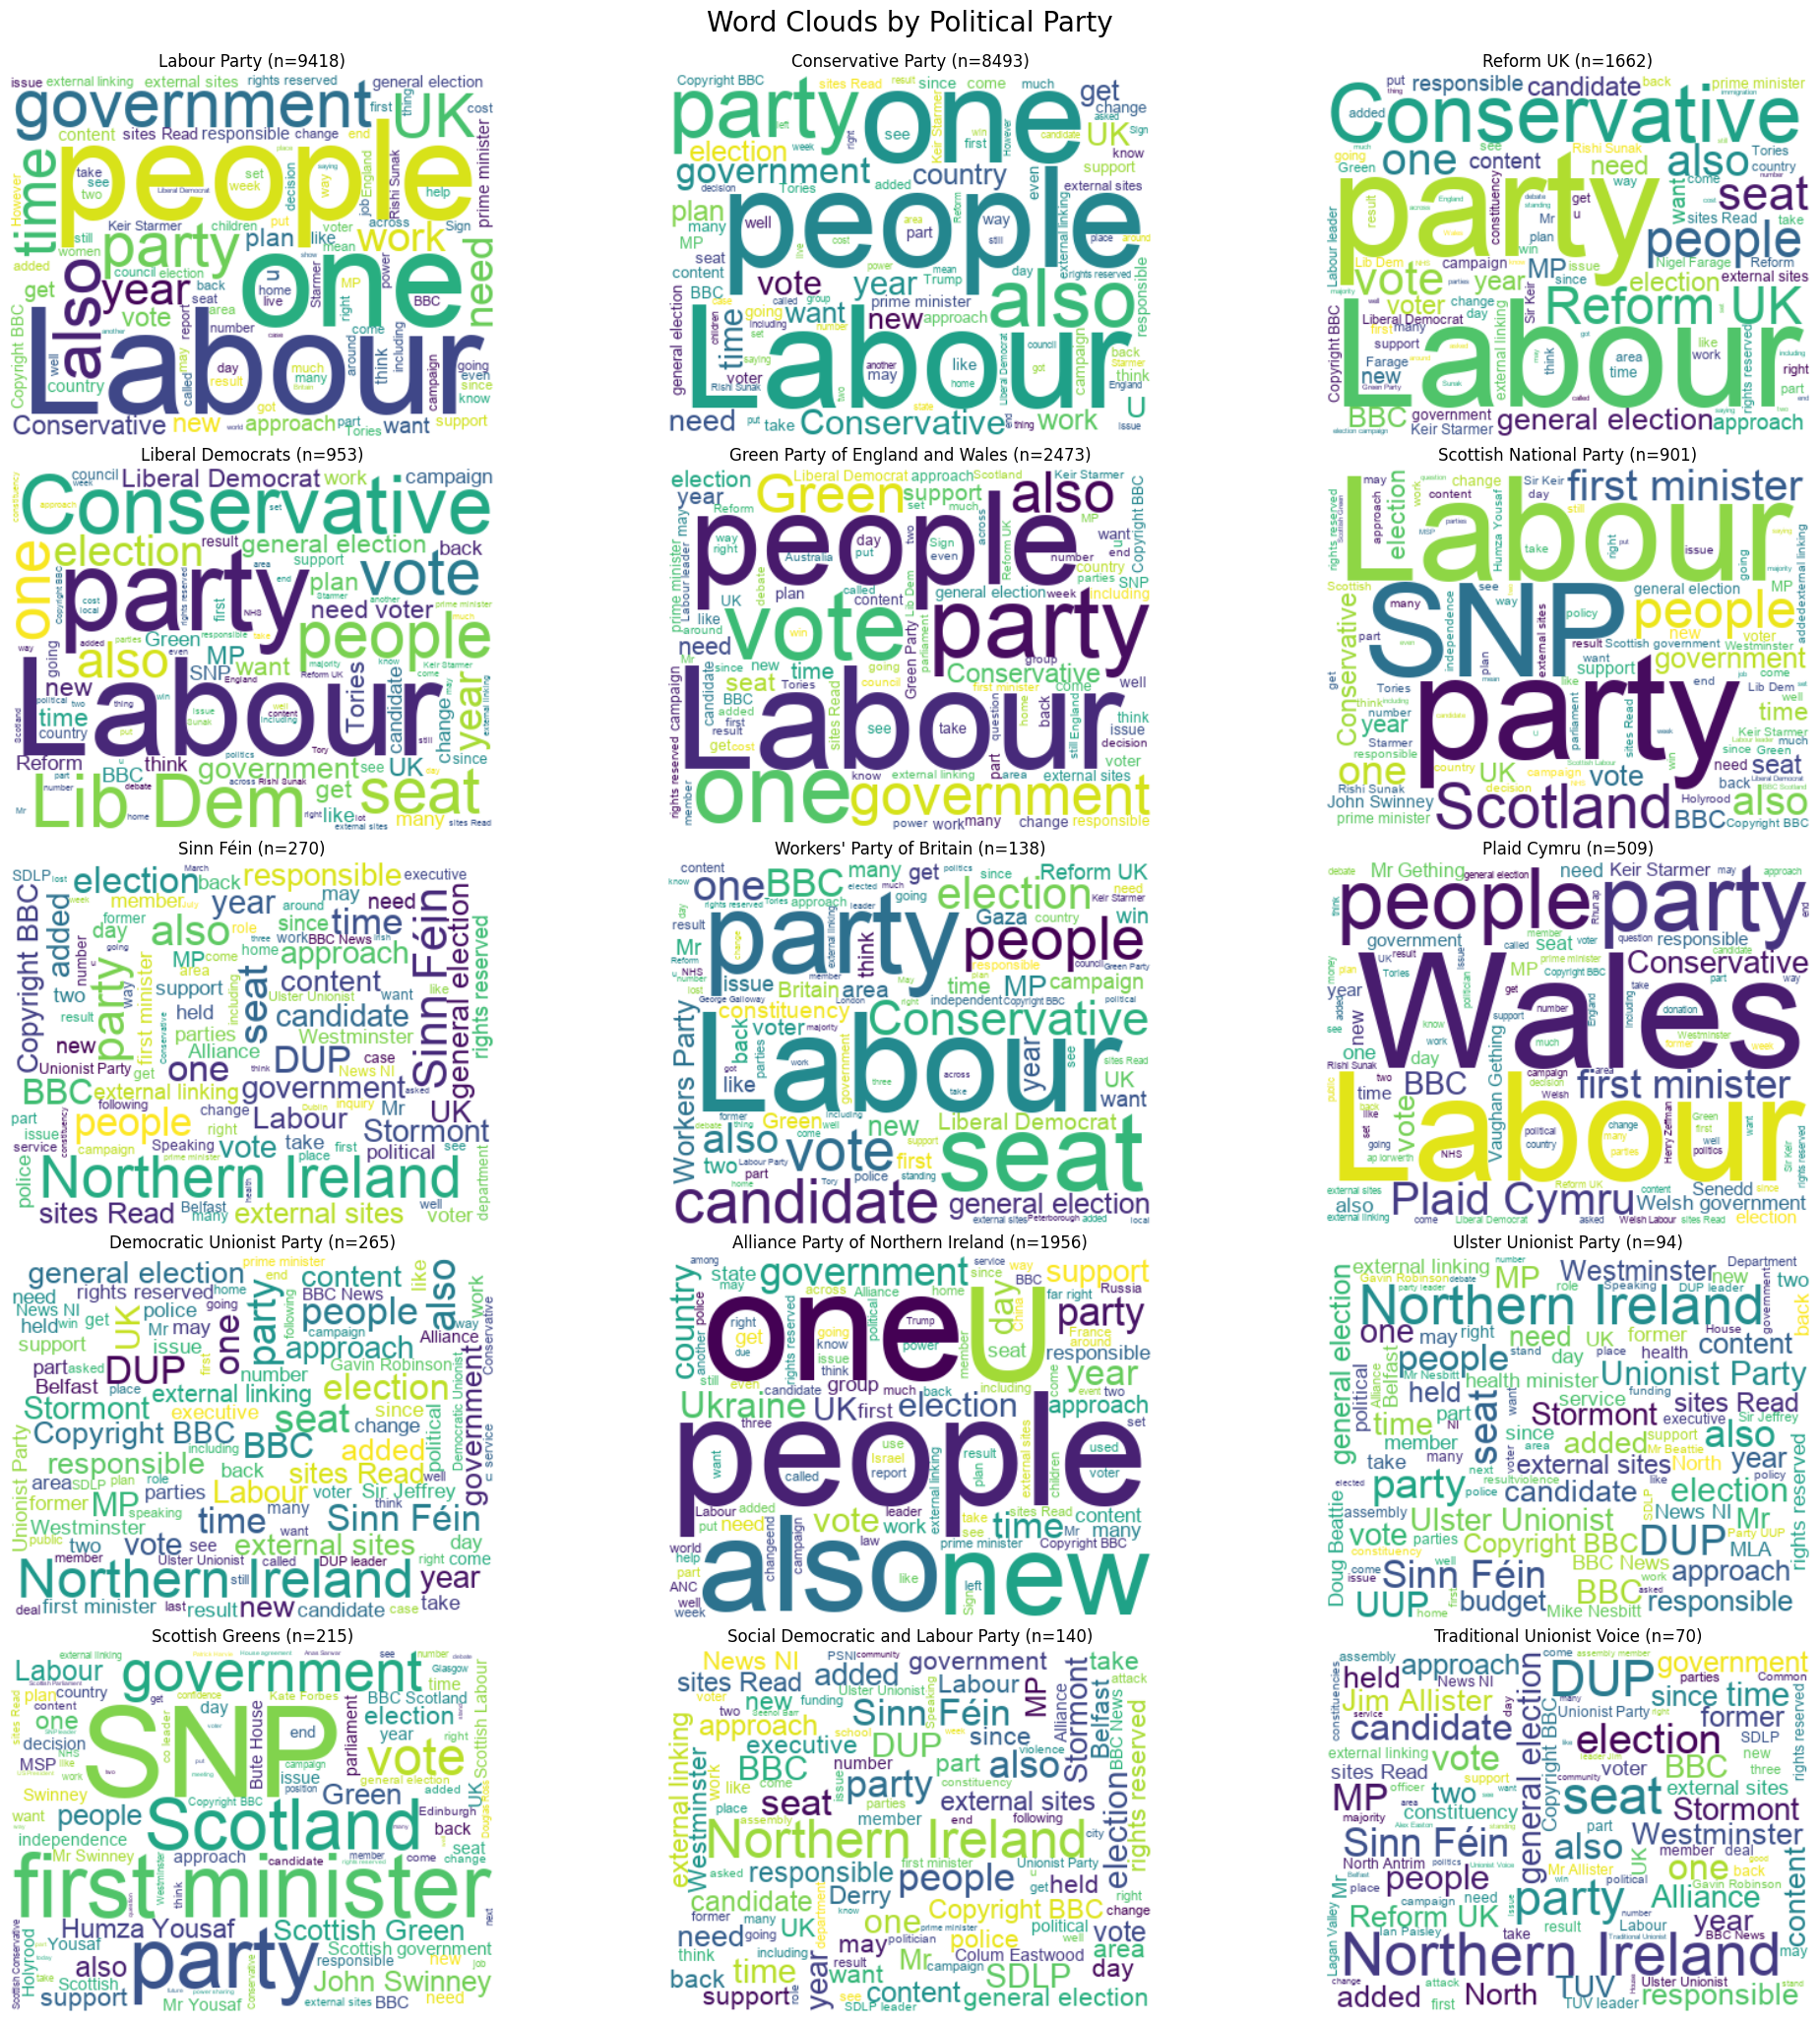

Extracting topics with LDA...: 100%|██████████| 15/15 [01:38<00:00,  6.54s/it]


In [50]:
uk_party_subsets, uk_top_words, uk_lda_results = analyze_party_mentions(uk_articles, 'UK')

In [51]:
uk_top_words_df = pd.DataFrame(uk_top_words)
uk_lda_results_df = pd.DataFrame(uk_lda_results)

In [52]:
uk_top_words_df

Labour Party Conservative Party      Reform UK Liberal Democrats  \
0        labour             labour         labour            labour   
1           bbc              party          party             party   
2         party             people            bbc          election   
3        people                bbc       election               bbc   
4    government           election             uk            people   
5            uk         government         reform                uk   
6      election                 uk         people               lib   
7           one                one         leader        government   
8           new                new   conservative               one   
9          also               also             mr      conservative   
10        first              first       external     conservatives   
11         year       conservative            one            leader   
12        years               year            new               new   
13         time                 mr  conservatives              also   
14           mr              years           also             first   
15     minister           minister         farage             seats   
16     external                 us       campaign              vote   
17          two               time     government          minister   
18      council              trump          first            reform   
19         last             leader        general          campaign   

   Green Party of England and Wales Scottish National Party   Sinn Féin  \
0                            labour                  labour       party   
1                             party                   party     ireland   
2                               bbc                scotland    northern   
3                          election                     snp         bbc   
4                            people                scottish    election   
5                        government              government          mr   
6                                uk                election      leader   
7                               new                   first        sinn   
8                            leader                minister        féin   
9                             first                     bbc         dup   
10                              one                  leader      people   
11                             also                      uk        also   
12                         minister                      mr       first   
13                           greens                  people    minister   
14                             year                 swinney    external   
15                             vote                     new  government   
16                               mr                    also        time   
17                            green                     one          uk   
18                             time                    vote     belfast   
19                         external                external         one   

   Workers' Party of Britain    Plaid Cymru Democratic Unionist Party  \
0                     labour         labour                     party   
1                      party          wales                   ireland   
2                        bbc          welsh                  northern   
3                   election          party                       bbc   
4                     people     government                       dup   
5                 candidates            bbc                  election   
6                         uk       minister                    leader   
7                  candidate             uk                        mr   
8               conservative          first                  minister   
9                         mr       election                      also   
10                       one             mr                    people   
11                      seat        gething                

In [53]:
uk_lda_results_df

Labour Party  \
0     [bbc, council, external, people, police]   
1          [people, government, one, uk, year]   
2  [labour, party, election, minister, leader]   

                          Conservative Party  \
0         [bbc, government, mr, uk, council]   
1        [trump, people, us, one, president]   
2  [labour, party, election, sunak, starmer]   

                                         Reform UK  \
0  [labour, party, election, reform, conservative]   
1              [labour, leader, bbc, uk, election]   
2                [bbc, people, uk, external, year]   

                             Liberal Democrats  \
0  [bbc, labour, council, party, conservative]   
1        [people, government, uk, bbc, labour]   
2       [labour, party, election, sunak, vote]   

                  Green Party of England and Wales  \
0                   [people, one, year, also, new]   
1  [government, minister, snp, scottish, scotland]   
2           [labour, party, election, bbc, leader]   

                      Scottish National Party  \
0  [scottish, snp, scotland, minister, first]   
1  [labour, party, election, leader, starmer]   
2  [government, uk, labour, people, scotland]   

                                        Sinn Féin  \
0             [party, dup, northern, ireland, mr]   
1        [bbc, ireland, people, police, external]   
2  [party, election, ireland, labour, government]   

                        Workers' Party of Britain  \
0      [labour, party, election, seats, galloway]   
1  [bbc, party, labour, candidates, conservative]   
2            [people, party, one, like, election]   

                               Plaid Cymru  \
0         [watch, uk, bbc, henry, zeffman]   
1  [welsh, wales, gething, government, mr]   
2    [labour, party, election, uk, people]   

                  Democratic Unionist Party  \
0    [ireland, northern, bbc, mr, minister]   
1   [party, dup, leader, ireland, election]   
2  [labour, party, ireland, government, uk]   

           Alliance Party of Northern Ireland  \
0  [party, election, right, government, vote]   
1            [us, people, also, ukraine, one]   
2            [bbc, external, mr, council, uk]   

                       Ulster Unionist Party  \
0          [party, leader, mr, uup, nesbitt]   
1  [party, ireland, northern, election, dup]   
2       [people, ireland, northern, bbc, ni]   

                                 Scottish Greens  \
0    [snp, party, swinney, scottish, government]   
1  [scotland, scottish, labour, party, election]   
2        [first, minister, scottish, yousaf, mr]   

          Social Democratic and Labour Party  \
0   [ireland, bbc, northern, people, police]   
1  [ireland, party, northern, dup, election]   
2       [party, leader, election, sdlp, bbc]   

              Traditional Unionist Voice  
0  [party, dup, election, seat, ireland]  
1    [ireland, northern, bbc, mr, party]  
2   [mr, ireland, northern, police, bbc]